# Install and import required libraries

In [ ]:
!pip3 install transformers tiktoken auto-gptq Levenshtein numpy tqdm Cython &> /dev/null

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
from Levenshtein import distance
import matplotlib.pyplot as plt

# Helper functions for input perturbation and accuracy/robustness evaluation

In [ ]:
MAX_TOKENS = 510 # leave space for cls and oes

# Perturbation helpers
# Helper function to substitute token with random token
def substitution_mask(tokens, degree=5):
    if len(tokens) <= 1:
        return tokens.unsqueeze(0)
    for mask_id in np.random.randint(0, len(tokens)-1, size=degree if degree <= len(tokens)-1 else len(tokens)-1):
        tokens[mask_id] = np.random.randint(1000)
    return tokens.unsqueeze(0)

# Helper function to delete token from token_list
def deletion_mask(tokens, degree=5):
    if len(tokens) <= 1:
        return tokens.unsqueeze(0)
    for mask_id in np.random.randint(0, len(tokens)-1, size=degree if degree <= len(tokens)-1 else len(tokens)-1):
        tokens = torch.cat([tokens[:mask_id], tokens[mask_id+1:]])
    return tokens.unsqueeze(0)

# Helper function to insert random token in token_list
def insertion_mask(tokens, degree=5):
    if len(tokens) <= 1:
        return tokens.unsqueeze(0)[:MAX_TOKENS]
    counter = 0
    for mask_id in np.random.randint(0, len(tokens)-1, size=degree if degree <= len(tokens)-1 else len(tokens)-1):
        mask_id += counter
        temp = tokens[mask_id:]
        tokens = torch.cat([tokens[:mask_id], torch.tensor([np.random.randint(1000)], device='cuda:0')])
        tokens = torch.cat([tokens, temp])
        counter += 1
    return tokens.unsqueeze(0)[:MAX_TOKENS]

# Robustness helpers

# Load codeBERT model for tokenization
robustness_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base", max_length=MAX_TOKENS)
robustness_model = AutoModel.from_pretrained("microsoft/codebert-base")
# robustness_model.to(torch.device("cuda"))

def flatten_arrays(a, b):
    a = torch.flatten(a).detach().numpy()
    b = torch.flatten(b).detach().numpy()

    if len(a) > len(b):
        b = np.pad(b, (0, len(a)-len(b)))
    elif len(b) > len(a):
        a = np.pad(a, (0, len(b)-len(a)))

    return a, b

# Create latent representation for text
def code_embedding(function):
    tokens = robustness_tokenizer.tokenize(function)
    tokens=[robustness_tokenizer.cls_token] + tokens[:MAX_TOKENS] + [robustness_tokenizer.eos_token]
    tokens_ids = robustness_tokenizer.convert_tokens_to_ids(tokens)
    context_embeddings = robustness_model(torch.tensor(tokens_ids)[None,:])[0]

    # return context_embeddings
    return context_embeddings[0][0]

# Calculate cosine similarity
def cosine_similarity(a, b):
    # a, b = flatten_arrays(a, b)
    a = a.detach().numpy()
    b = b.detach().numpy()
    similarity = (np.dot(a, b)) / (np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
    # print(similarity)
    return similarity

# Calculate pearson correlation coefficient
def pearson_similarity(a, b):
    # a, b = flatten_arrays(a, b)
    a = a.detach().numpy()
    b = b.detach().numpy()
    corr, pval = pearsonr(a, b)
    # print(corr)
    return corr, pval

# Calculate spearman rank correlation
def spearman_similarity(a, b):
    # a, b = flatten_arrays(a, b)
    a = a.detach().numpy()
    b = b.detach().numpy()
    corr, pval = spearmanr(a, b)
    # print(corr)
    return corr, pval

# Calculate similarity scores
def average_similarity(a, b):
    cosine_score = cosine_similarity(a, b)
    pearson_score, _ = pearson_similarity(a, b)
    spearman_score, _ = spearman_similarity(a, b)
    # print((cosine_score + pearson_score + spearman_score) / 3)

    return (cosine_score + pearson_score + spearman_score) / 3

# usage:
# Test embedding functions
# original_out = code_embedding()
# perturbed_out = code_embedding()
# Test similarity function
# similarity_score = average_similarity(original_out, perturbed_out)


# Instantiate quantized CodeGen2.5 model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Codegen25-7B-mono-GPTQ",
                                          use_fast=True,
                                          trust_remote_code=True,
                                          max_length=MAX_TOKENS)

model = AutoGPTQForCausalLM.from_quantized("TheBloke/Codegen25-7B-mono-GPTQ",
        model_basename="model",
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        use_triton=False,
        quantize_config=None)
model.to(torch.device("cuda"))


A new version of the following files was downloaded from https://huggingface.co/TheBloke/Codegen25-7B-mono-GPTQ:
- tokenization_codegen25.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(51200, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): FusedLlamaAttentionForQuantizedModel(
          (qkv_proj): GeneralQuantLinear(in_features=4096, out_features=12288, bias=True)
          (o_proj): GeneralQuantLinear(in_features=4096, out_features=4096, bias=True)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (act_fn): SiLUActivation()
          (down_proj): GeneralQuantLinear(in_features=11008, out_features=4096, bias=True)
          (gate_proj): GeneralQuantLinear(in_features=4096, out_features=11008, bias=True)
          (up_proj): GeneralQuantLinear(in_features=4096, out_features=11008, bias=True)
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=51200, bias=

# Load Code Search Net dataset from HuggingFace

In [ ]:
DATASET_SIZE = 25

# Load the dataset as an iterable so that it can be streamed
ds = load_dataset("code_search_net", "python", streaming=True, split="test")
# Only relevant column is content since this has the code snips (not sure if this makes it faster)
ds = ds.select_columns(["whole_func_string", "func_code_string", "func_documentation_string"])
# Pick number of rows in dataset to sample
ds = ds.take(DATASET_SIZE)
# ds = ds.skip(19)

# usage:
# iterate over the dataset, every row is stored as a dict
# for item in iter(ds):
# # output row
#   print(item)

# Perform evaluation for various degrees of perturbation

In [ ]:
MAX_CODEGEN_LEN = 128 # runtime consideration

dists = []
base_dists = []
deletion_dists = []
insertion_dists = []
substitution_dists = []
similarity = []
similarity_ref = []

perturbation_interval = range(5, 55, 5)

for degree in tqdm(perturbation_interval):
  for item in tqdm(iter(ds)):
  # output row
    # print(item)
    prompt = f"""\n{item["func_code_string"].split(":")[0]}:\n'''{item["func_documentation_string"]}'''"""
    prompt_template=f'''{prompt}'''
    ground_truth = item['whole_func_string']
    # print(f"Prompt: {prompt_template}\n")
    # print("Generating... \n")

    reference_out = code_embedding(ground_truth)

    # generate using function name and docstring as input
    input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
    output = model.generate(inputs=input_ids, temperature=0.7, max_new_tokens=MAX_CODEGEN_LEN)
    generated_output = tokenizer.decode(output[0])
    original_out = code_embedding(generated_output)
    dists.append(distance(ground_truth, generated_output)/len(ground_truth))
    similarity_score = average_similarity(reference_out, original_out)

    # delete n tokens from input
    deletion_id = deletion_mask(input_ids[0], degree=degree)
    deletion_output = model.generate(inputs=deletion_id, temperature=0.7, max_new_tokens=MAX_CODEGEN_LEN)
    generated_deletion_output = tokenizer.decode(deletion_output[0])
    deletion_out = code_embedding(generated_deletion_output)
    similarity_score_delete = average_similarity(original_out, deletion_out)
    similarity_score_ref_delete = average_similarity(reference_out, deletion_out)
    deletion_dists.append(distance(ground_truth, generated_deletion_output)/len(ground_truth))
    base_dists.append(distance(generated_output, generated_deletion_output)/len(ground_truth))

    # insert n tokens in input
    insertion_id = insertion_mask(input_ids[0], degree=degree)
    insertion_output = model.generate(inputs=insertion_id, temperature=0.7, max_new_tokens=MAX_CODEGEN_LEN)
    generated_insertion_output = tokenizer.decode(insertion_output[0])
    insertion_out = code_embedding(generated_insertion_output)
    similarity_score_insert = average_similarity(original_out, insertion_out)
    similarity_score_ref_insert = average_similarity(reference_out, insertion_out)
    insertion_dists.append(distance(ground_truth, generated_insertion_output)/len(ground_truth))
    base_dists.append(distance(generated_output, generated_insertion_output)/len(ground_truth))

    # substitute n tokens in input with random token
    substitution_id = substitution_mask(input_ids[0], degree=degree)
    substitution_output = model.generate(inputs=substitution_id, temperature=0.7, max_new_tokens=MAX_CODEGEN_LEN)
    generated_substitution_output = tokenizer.decode(substitution_output[0])
    substitution_out = code_embedding(generated_substitution_output)
    similarity_score_sub = average_similarity(original_out, substitution_out)
    similarity_score_ref_sub = average_similarity(reference_out, substitution_out)
    substitution_dists.append(distance(ground_truth, generated_substitution_output)/len(ground_truth))
    base_dists.append(distance(generated_output, generated_substitution_output)/len(ground_truth))

    similarity.append((similarity_score_delete, similarity_score_insert, similarity_score_sub))
    similarity_ref.append((similarity_score, similarity_score_ref_delete, similarity_score_ref_insert, similarity_score_ref_sub))


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(

1it [00:33, 33.27s/it]
2it [01:04, 31.90s/it]
3it [01:43, 35.06s/it]
4it [02:14, 33.76s/it]
5it [02:47, 33.49s/it]
6it [03:19, 33.00s/it]
7it [03:51, 32.59s/it]
8it [04:23, 32.46s/it]
9it [04:53, 31.64s/it]
10it [05:28, 32.72s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors

11it [05:57, 31.44s/it]
12it [06:29, 31.82s/it]
13it [07:02, 32.17s/it]
14it [07:35, 32.25s/it]
15it [08:07, 32.20s/it]
16it [08:39, 32.09s/it]
17it [09:09, 31.40s/it]
18it [09:38, 30.69s/it]
19it [10:07, 30.19s/it]
20it 

In [ ]:
# sanity check
delete_sim = [item[0] for item in similarity]
insert_sim = [item[1] for item in similarity]
sub_sim = [item[2] for item in similarity]

ref_sim = [item[0] for item in similarity_ref]
ref_delete_sim = [item[1] for item in similarity_ref]
ref_insert_sim = [item[2] for item in similarity_ref]
ref_sub_sim = [item[3] for item in similarity_ref]

print(f" dists:\t\t\t{dists}, \
      \n deletion_dists:\t{deletion_dists}, \
      \n insertion_dists:\t{insertion_dists}, \
      \n substitution_dists:\t{substitution_dists}, \
      \n base_deletion_dists:\t{base_dists[::3]}, \
      \n base_insertion_dists:\t{base_dists[1::3]}, \
      \n base_subs_dists:\t{base_dists[2::3]}, \
      \n similarity:\t\t{similarity}, \
      \n delete_sim:\t\t{delete_sim}, \
      \n insert_sim:\t\t{insert_sim}, \
      \n sub_sim:\t\t{sub_sim}, \
      \n ref_similarity:\t\t{ref_sim}, \
      \n ref_delete_sim:\t\t{ref_delete_sim}, \
      \n ref_insert_sim:\t\t{ref_insert_sim}, \
      \n ref_sub_sim:\t\t{ref_sub_sim}")


 dists:			[0.7560975609756098, 0.8, 0.9187279151943463, 0.6586206896551724, 0.65875, 0.7844311377245509, 0.6425855513307985, 0.520618556701031, 0.497787610619469, 0.3473193473193473, 0.7872340425531915, 0.7820015515903801, 0.6089385474860335, 0.5608214849921012, 0.37971391417425226, 0.6580406654343808, 1.1666666666666667, 1.89937106918239, 1.9695121951219512, 1.9872611464968153, 0.7073825503355705, 0.7309697601668405, 0.6345514950166113, 0.5425038639876353, 0.23420647149460708, 0.7560975609756098, 0.8, 0.9187279151943463, 0.6586206896551724, 0.65875, 0.7844311377245509, 0.6425855513307985, 0.520618556701031, 0.497787610619469, 0.3473193473193473, 0.7872340425531915, 0.7820015515903801, 0.6089385474860335, 0.5608214849921012, 0.37971391417425226, 0.6580406654343808, 1.2182539682539681, 1.89937106918239, 1.9695121951219512, 1.9872611464968153, 0.7073825503355705, 0.7309697601668405, 0.6345514950166113, 0.5425038639876353, 0.23420647149460708, 0.7560975609756098, 0.8, 0.9187279151943463, 

# Visualize results

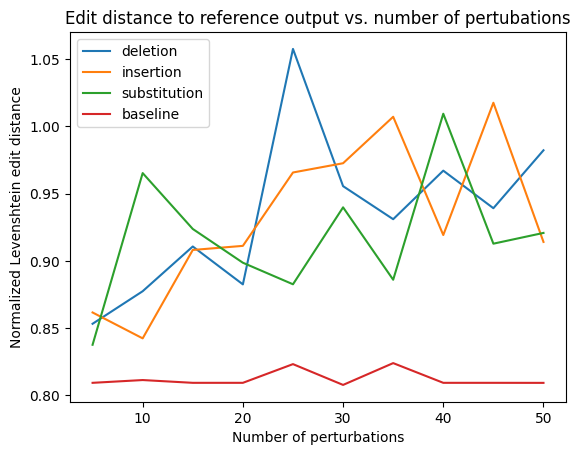

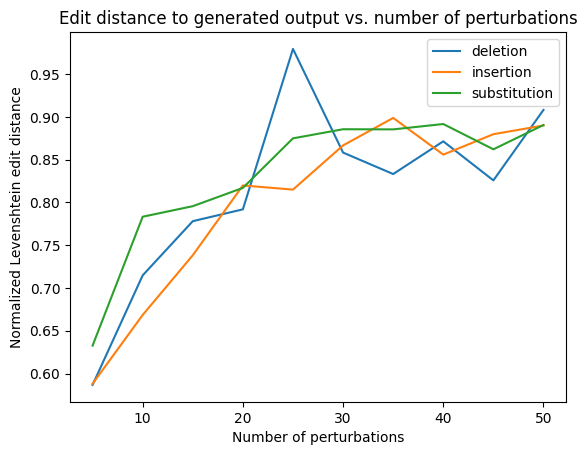

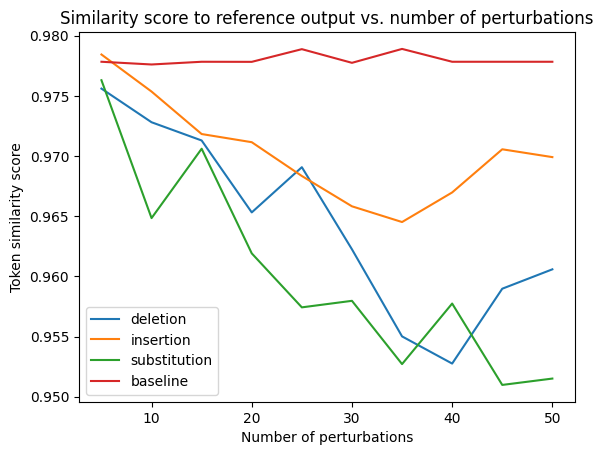

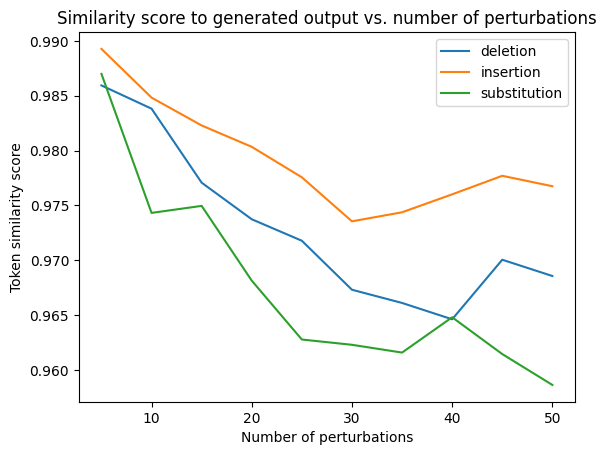

<Figure size 640x480 with 0 Axes>

In [ ]:
# vary the degree of perturbation and plot it
# perturbation_interval = range(5, 40, 5)
def average_dist(elements, n):
  avg_dists = []
  for i in range(0, len(elements), n):
    avg_dists.append(sum(elements[i:i+n])/n)
  return avg_dists # [:7]

# plot edit distances against ground truth
plt.plot([degree for degree in perturbation_interval], average_dist(deletion_dists, DATASET_SIZE), label="deletion")
plt.plot([degree for degree in perturbation_interval], average_dist(insertion_dists, DATASET_SIZE), label="insertion")
plt.plot([degree for degree in perturbation_interval], average_dist(substitution_dists, DATASET_SIZE), label="substitution")
plt.plot([degree for degree in perturbation_interval], average_dist(dists, DATASET_SIZE), label="baseline")
plt.title("Edit distance to reference output vs. number of pertubations")
plt.xlabel("Number of perturbations")
plt.ylabel("Normalized Levenshtein edit distance")
plt.legend()
plt.show()
plt.savefig('dist_vs_groundtruth.svg')

# plot edit distances of perturbed inputs relative to baseline generation
plt.plot([degree for degree in perturbation_interval], average_dist(base_dists[::3], DATASET_SIZE), label="deletion")
plt.plot([degree for degree in perturbation_interval], average_dist(base_dists[1::3], DATASET_SIZE), label="insertion")
plt.plot([degree for degree in perturbation_interval], average_dist(base_dists[2::3], DATASET_SIZE), label="substitution")
plt.title("Edit distance to generated output vs. number of perturbations")
plt.xlabel("Number of perturbations")
plt.ylabel("Normalized Levenshtein edit distance")
plt.legend()
plt.show()
plt.savefig('dist_vs_baseline.svg')

# plot similarity scores of perturbed inputs against ground truth
plt.plot([degree for degree in perturbation_interval], average_dist(ref_delete_sim, DATASET_SIZE), label="deletion")
plt.plot([degree for degree in perturbation_interval], average_dist(ref_insert_sim, DATASET_SIZE), label="insertion")
plt.plot([degree for degree in perturbation_interval], average_dist(ref_sub_sim, DATASET_SIZE), label="substitution")
plt.plot([degree for degree in perturbation_interval], average_dist(ref_sim, DATASET_SIZE), label="baseline")
plt.title("Similarity score to reference output vs. number of perturbations")
plt.xlabel("Number of perturbations")
plt.ylabel("Token similarity score")
plt.legend()
plt.show()
plt.savefig('sim_vs_groundtruth.svg')

# plot similarity scores of perturbed inputs against baseline generation
plt.plot([degree for degree in perturbation_interval], average_dist(delete_sim, DATASET_SIZE), label="deletion")
plt.plot([degree for degree in perturbation_interval], average_dist(insert_sim, DATASET_SIZE), label="insertion")
plt.plot([degree for degree in perturbation_interval], average_dist(sub_sim, DATASET_SIZE), label="substitution")
plt.title("Similarity score to generated output vs. number of perturbations")
plt.xlabel("Number of perturbations")
plt.ylabel("Token similarity score")
plt.legend()
plt.show()
plt.savefig('sim_vs_baseline.svg')
